In [2]:
!pip3 install sympy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from sympy import * 
from sympy.abc import * 
from random import random, randint
init_printing(num_columns=4)

r = lambda: random() + 0.1

In [4]:
C_1, C_2, w_t, h_t, r_t, S_t, K_t, L_t, k_t, k_t1, r_t1, K_t1, L_t1, p_t, N_t = symbols(
    'C_1, C_2, w_t, h_t, r_t, S_t, K_t, L_t, k_t, k_{t+1}, r_{t+1}, K_{t+1}, L_{t+1}, p_t, N_t',
    real=True, positive=True
)
l = Symbol('lambda')
sigma = Symbol('ς')
alpha = Symbol('alpha', positive=True)

### Решение задачи потребителя

<ul>
    <li> Налог на трудовой доход
        $$ 
        C_{1, t} + S_t = h_t \cdot w_t \cdot (1 - \tau)
        $$
        $$
        C_{2, t+1} = S_t \cdot (1 + r_t) 
        $$
    <li> Налог на валовый процентный доход
        $$ 
        C_{1, t} + S_t = h_t \cdot w_t 
        $$
        $$
        C_{2, t+1} = S_t \cdot (1 + r_t) \cdot (1 - \tau)
        $$
    <li> Субсидия на трудовой доход
        $$ 
        C_{1, t} + S_t = h_t \cdot w_t \cdot (1 + ς)
        $$
        $$
        C_{2, t+1} = S_t \cdot (1 + r_t) 
        $$
</ul>

In [5]:
index = randint(0, 2)  # заменить на нужный номер № вар. - 1
all_equatations = [
    [
        C_1 + S_t - h_t * w_t,
        C_2 - S_t * (1 + r_t) * (1 - tau)
    ], 
    [
        C_1 + S_t - h_t * w_t * (1 - tau),
        C_2 - S_t * (1 + r_t) 
    ], 
    [
        C_1 + S_t - h_t * w_t * (1 + sigma),
        C_2 - S_t * (1 + r_t)
    ]
]
all_equatations

In [6]:
all_BC = [
    eq[0].subs(solve(eq[1], S_t, dict=True)[0]) for eq in all_equatations
]
all_BC

#### Бюджетное ограничение

Здесь выбирается нужное МБО 

In [7]:
BC = all_BC[index]
equatations = all_equatations[index]
{Symbol("BC"): BC}

#### Функция полезности

In [8]:
U = ln(C_1) + psi * ln(1 - h_t) + beta * ln(C_2)
{Symbol("U"): U}

#### Лагранж

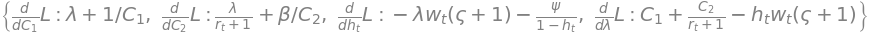

In [9]:
L = U + l * BC
consumer_control = (C_1, C_2, l, h_t)   # переменные, по которым мы дифференцируем
partials = {Derivative(Symbol("L"), i): diff(L, i) for i in consumer_control}
partials

#### Решение

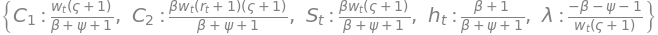

In [10]:
consumer_solution = solve(partials.values(), consumer_control, dict=True)[0]
consumer_solution.update({S_t: solve(equatations[0], S_t)[0].subs(consumer_solution).simplify()})
consumer_solution

### Решение задачи фирмы

#### Производственная функция

In [11]:
Y_t = K_t ** alpha * L_t ** (1 - alpha)
{Symbol("Y_t"): Y_t}

#### Функция прибыли

In [12]:
revenue = Y_t * p_t
costs = w_t * L_t + r_t * K_t 
pi = revenue - costs 
## you can also 
# pi = pu.subs({p_t: 1})
{Symbol("pi"): pi}

#### Дифференцирование функции прибыли

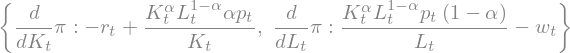

In [13]:
firm_control = (K_t, L_t)
partials = {Derivative(Symbol("pi"), i): diff(pi, i) for i in firm_control}
partials

#### Решение для фирмы

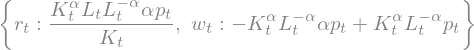

In [14]:
firm_solution = solve(partials.values(), (w_t, r_t))
firm_solution

In [15]:
solution = consumer_solution.copy()
solution.update(firm_solution)

**применим хитрость. нюанс, так сказать**

$$ k_t = \frac{K_t}{L_t} \Rightarrow \begin{cases} K_t = k_t \cdot L_t \\ L_t = \frac{K_t}{k_t}\end{cases}$$

In [16]:
y_t = (Y_t / L_t).subs({L_t: K_t / k_t, K_t: k_t * L_t},simultaneous=False).simplify()
{Symbol("y_t"): y_t}

In [17]:
intensive_solution = {k: 
    v.subs({L_t: K_t / k_t, K_t: k_t * L_t}, simultaneous=False).simplify() 
    for k, v in firm_solution.items()}
intensive_solution

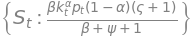

In [18]:
s_sol = {S_t: solution.get(S_t).subs(intensive_solution)}
intensive_solution.update(s_sol)
s_sol

#### И дальше проблема.

Либо $ K_{t+1} = N_t \cdot s_t \cdot h_t$, либо $ K_{t+1} = N_t \cdot s_t $. Вероятно, второй вариант

In [19]:
#  vars_t1 = {K_t1: N_t * h_t * S_t, L_t1: h_t * N_t * (1 + n)}
vars_t1 = {K_t1: N_t * S_t, L_t1: h_t * N_t * (1 + n)} 
vars_t1

#### Выразить $ k_{t+1} $

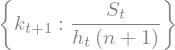

In [20]:
var_k1 = {k_t1: (K_t1 / L_t1).subs(vars_t1)}
intensive_solution.update(var_k1)
var_k1

#### Выразить $ k_{t+1}$  через $ k_t $

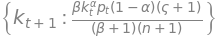

In [27]:
dynamic_k1 = {k_t1: var_k1.get(k_t1).subs(s_sol).subs(consumer_solution)}
dynamic_k1

#### Стационарное состояние

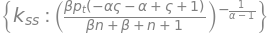

In [28]:
k_ss = Symbol("k_{ss}", positive=True)
ss = {k_ss: solve(dynamic_k1.get(k_t1) - k_t, k_t)[0]}
ss

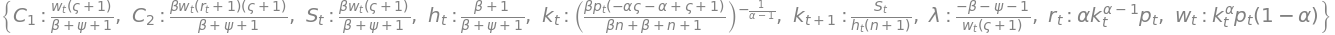

In [29]:
total_solution = intensive_solution
total_solution.update(consumer_solution)
total_solution.update({k_t: ss.get(k_ss)})
total_solution

#### Подстановка значений из словаря

In [33]:
values = {
    beta: r(), 
    alpha: r(), 
    n: r(), 
    sigma: r(), 
    psi: r(),
    p_t: 1, 
    tau: r(),
}

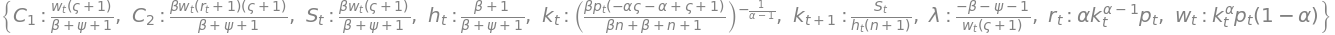

In [34]:
total_solution

In [35]:
sol = {k: v.subs(total_solution).subs(values) for k, v in total_solution.items()}
answer = {k: v.subs(sol).round(3) for k, v in sol.items()}
answer